## Introduction
Let's download dataset

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

We would work with LibriSpeech, a substantial open-source dataset, consists of read-speech recordings sampled at 16 kHz. It encompasses more than 1000 hours of audio books sourced from the LibriVox project. The dataset provides transcripts meticulously aligned at the sentence level, as detailed in the work by [Panayotov et al. in 2015](https://ieeexplore.ieee.org/document/7178964).


## What is ASR?
Automatic Speech Recognition (ASR) is a technology that enables machines to transcribe spoken language into text. This process involves analyzing and interpreting audio waveforms to produce accurate textual representations of spoken words. While ASR has made significant advancements, achieving perfect transcription across various contexts and speakers remains a challenge.

Challenges:
1. **Context and Vocabulary:**
  * ASR systems must accurately transcribe spoken words into textual form. Tasks range from simple commands with limited vocabulary to complex conversations with extensive lexicons.
  * Simple tasks like digit recognition or binary commands exhibit high accuracy, while transcribing conversations or videos with diverse vocabularies poses greater difficulty.
1. **Speaker Variability:**
  * Recognizing speech depends on the speaker's characteristics and the context of communication. Machines generally perform better when humans interact with them directly or when speech is read aloud.
  * Conversational speech, especially in scenarios like business meetings, presents the greatest challenge due to natural variations, interruptions, and overlapping speech.
1. **Environmental Factors:**
  * The environment in which speech is recorded significantly impacts recognition accuracy. Clean, quiet settings with close-range microphones yield better results compared to noisy environments or recordings made at a distance.
  * Noise, such as background chatter or vehicle sounds, can distort speech signals and hinder transcription accuracy.
1. **Accent and Dialect:**
  * ASR systems perform best when trained on speech patterns similar to those they encounter during operation. Recognizing accents, dialects, or speech variations not present in the training data poses difficulties.
  * Variations in pronunciation, intonation, and regional speech patterns challenge ASR accuracy, particularly when encountering diverse speaker demographics.

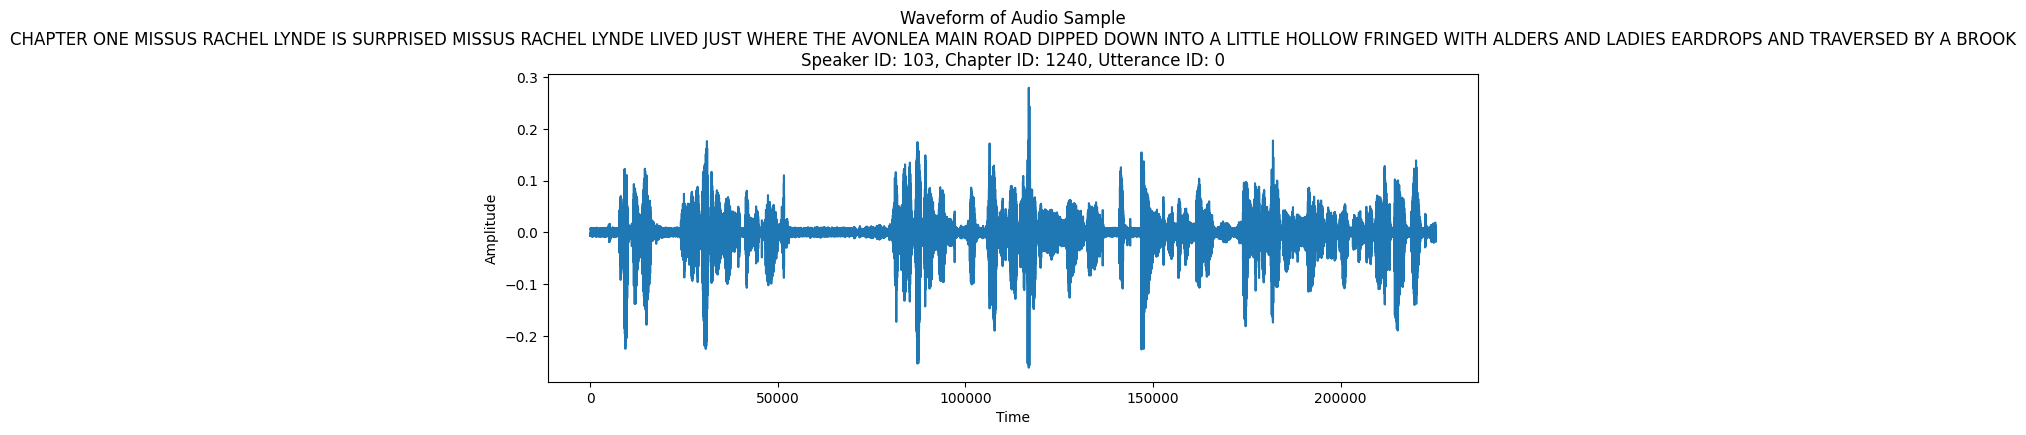

In [3]:
import torchaudio
import os
import matplotlib.pyplot as plt

if not os.path.isdir("../../data/librispeech"):
    os.makedirs("../../data/librispeech")
train_dataset = torchaudio.datasets.LIBRISPEECH("../../data/librispeech", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("../../data/librispeech", url="test-clean", download=True)

waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = train_dataset[0]
# Plot the waveform
plt.figure(figsize=(12, 4))
plt.plot(waveform.t().numpy())
plt.title(f'Waveform of Audio Sample\n{utterance}\nSpeaker ID: {speaker_id}, Chapter ID: {chapter_id}, Utterance ID: {utterance_id}')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [4]:
import IPython.display as ipd
ipd.Audio(waveform.numpy(), rate=sample_rate)

## Why ASR is important?
ASR technology finds application in various domains, including:

* Human-machine interfaces, enabling voice commands for smart devices and personal assistants. (Siri, Amazon Alexa, Google Assitant)
* Telephony systems for call-routing and automated customer service interactions. (Virtual Call Center in Vodafone or Kyivstar)
* Captioning for audio and video content, enhancing accessibility and user experience. (YouTube, Netflix)
* Transcription services for generating textual records of speeches, interviews, or discussions. (Otter.ai)
* Dictation software for professionals in fields like law and medicine, aiding in documentation tasks. (OpenAI Whisper)

## ASR metrics
An objective of ASR can be stated, as to develop a model that reduces the Word Error Rate (WER) metric when converting speech input into text. Essentially, when presented with an audio file, such as a WAV file containing speech, our aim is to accurately transcribe it into text with minimal errors.








In [5]:
import numpy as np

def levenshtein_distance(ref, hyp):
    """Calculates the Levenshtein distance between two sequences."""
    m, n = len(ref), len(hyp)

    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    previous_row = range(n + 1)
    for i, c1 in enumerate(ref):
        current_row = [i + 1]
        for j, c2 in enumerate(hyp):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]

def normalize_text(text, ignore_case=False, remove_space=False):
    """Normalizes text based on the specified conditions."""
    if ignore_case:
        text = text.lower()
    if remove_space:
        text = ''.join(text.split())
    return text

def calculate_errors(reference, hypothesis, ignore_case=False, remove_space=False, delimiter=None):
    """Calculates edit distance and length/reference length based on the mode (word or char level)."""
    reference = normalize_text(reference, ignore_case, remove_space)
    hypothesis = normalize_text(hypothesis, ignore_case, remove_space)

    if delimiter:
        reference = reference.split(delimiter)
        hypothesis = hypothesis.split(delimiter)

    edit_distance = levenshtein_distance(reference, hypothesis)
    ref_len = len(reference)

    return float(edit_distance), ref_len

def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculates word error rate."""
    edit_distance, ref_len = calculate_errors(reference, hypothesis, ignore_case, False, delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    return edit_distance / ref_len

def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculates character error rate."""
    edit_distance, ref_len = calculate_errors(reference, hypothesis, ignore_case, remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    return edit_distance / ref_len

In [6]:
cer("olya", "olya")

0.0

## ASR approaches

Traditional speech recognition systems adopt a generative approach, meticulously modeling the entire process through which spoken words are produced to assess a given speech sample. This process begins with a language model that predicts the most probable sequence of words (e.g., using an n-gram model), proceeds to a pronunciation model that specifies how each word is pronounced (e.g., via a pronunciation dictionary), and culminates in an acoustic model that maps these pronunciations to sound waves (e.g., employing a Gaussian Mixture Model).

When processing spoken input, the objective is to identify the text sequence that most likely would produce the observed audio, based on this comprehensive model framework. Essentially, traditional speech recognition aims to maximize the product of the probability of the audio given the transcript and the probability of the transcript itself, selecting the most probable transcript as the output.

As neural network technologies evolved, they began to outperform each component of the traditional speech recognition framework, offering enhanced accuracy and better generalization capabilities. Neural networks could take the place of  n-gram models with more sophisticated neural language models, swap out pronunciation dictionaries for neural pronunciation models, and so on. However, each neural component requires individual training on specific tasks, and inaccuracies in any single component could compromise the overall performance.



## End-To-End ASR

In an end-to-end model, the goal is to directly learn the probability of a transcript given the audio input, allowing for the prediction of text directly from the original sound. Given that this involves processing sequential data—audio signals over time corresponding to a sequence of text characters—Recurrent Neural Networks (RNNs) naturally come to the fore as a suitable solution. However, a significant challenge arises due to the mismatch in sequence lengths between the input audio (comprising numerous time steps) and the desired textual output (the length of the transcript). This discrepancy poses the question: How do we accurately align each time step of the audio data with the appropriate characters in the output transcript?


Traditional approaches to speech recognition depended on data where each portion of the audio was directly linked to a specific speech sound, like a phoneme or word. This method allowed for precise alignment but was limited in flexibility, especially for letter-by-letter prediction which can mitigate out-of-vocabulary (OOV) issues. In this scenario, every audio time step would need to be tagged with the corresponding letter sound being produced at that moment. Ideally, this would enable the prediction of the correct letter at each time step, with subsequent merging of consecutive identical letters (for example, turning "BBLLOCK" into "BLOCK"). However, this approach faces significant hurdles: not only is the process of aligning the dataset with letter sounds exceedingly time-consuming, but it also fails to address cases with inherently repeating letters in words, such as "look." Merely merging identical letters would not be an effective solution in these situations.

Modern end-to-end approaches get around this using methods that don't require manual alignment at all, so that the input-output pairs are really just the raw audio and the transcript--no extra data or labeling required. Let's briefly go over two popular approaches that allow us to do this, Connectionist Temporal Classification (CTC) and sequence-to-sequence models with attention.

### Connectionist Temporal Classification (CTC)

In speech recognition, typical outputs include characters like A-Z, numbers, and spaces. CTC (Connectionist Temporal Classification) introduces a novel solution to the alignment problem with a "blank token" ("-"). This allows for distinguishing between characters and managing sequences with repeating letters.

Using CTC, each time segment of speech predicts a token, utilizing the blank token to determine where predictions should not be merged. For example, predictions for an 11-time-step audio snippet like "LOO-OOO--KK" would collapse to "LO-O-K," and after removing blank tokens, the final output would be "LOOK."

**How to train such models?**

$\log(P(output=\text{LOOK}|audio)) = \log(P(\text{LOO-OOO--KK}|audio)) + \log(P(\text{LLO--OO-KKK}|audio)) + ....$

In practical terms, a dynamic programming strategy can be employed to compute this by aggregating the log probabilities across various "paths" that navigate through the softmax outputs at each temporal step.

### Sequence-to-Sequence with Attention

CTC faces a limitation as it assumes predictions at different time steps are conditionally independent, ignoring the natural linguistic relationships between words in a continuous speech. While adding an external language model to CTC outputs can partially address this, a more cohesive solution is found in sequence-to-sequence (seq2seq) models with attention mechanisms.

In a seq2seq approach for ASR, a bidirectional RNN encoder processes the audio sequence, with its outputs then fed into an attention-based decoder. This decoder makes predictions by focusing on specific parts of the input sequence and considering previously generated tokens.

## Data preparation

### Text Transformation

In [7]:
import string

class TextTransform:
    """Maps characters to integers and vice versa, using the string module for character definitions."""
    def __init__(self):
        # Including additional characters manually and using string.ascii_lowercase for letters
        additional_chars = ["'", "<SPACE>"]
        all_chars = additional_chars + list(string.ascii_lowercase)

        # Generating char_map with enumeration, starting indices from 0
        self.char_map = {char: i for i, char in enumerate(all_chars)}

        # Inverting char_map to create index_map
        self.index_map = {index: char for char, index in self.char_map.items()}
        self.index_map[self.char_map['<SPACE>']] = ' '  # Ensuring space is correctly mapped

    def text_to_int(self, text):
        """Converts text to an integer sequence using a character map."""
        return [self.char_map.get(c, self.char_map['<SPACE>']) for c in text.lower()]

    def int_to_text(self, labels):
        """Converts integer labels to a text sequence using a character map."""
        return ''.join(self.index_map[i] for i in labels).replace('<SPACE>', ' ')

# Usage example
text_transform = TextTransform()
test_text = "Hello world"
test_ints = text_transform.text_to_int(test_text)
recovered_text = text_transform.int_to_text(test_ints)

print(f"Original: {test_text}")
print(f"Converted to ints: {test_ints}")
print(f"Recovered text: {recovered_text}")

Original: Hello world
Converted to ints: [9, 6, 13, 13, 16, 1, 24, 16, 19, 13, 5]
Recovered text: hello world


### How to convert labels of different sizes to batches?

In [8]:
import torch
import torch.nn as nn

text_transform = TextTransform()

texts = ["Hello world", "My name is Oles"]
labels = [torch.Tensor(text_transform.text_to_int(text)) for text in texts]
labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)
labels

tensor([[ 9.,  6., 13., 13., 16.,  1., 24., 16., 19., 13.,  5.,  0.,  0.,  0.,
          0.],
        [14., 26.,  1., 15.,  2., 14.,  6.,  1., 10., 20.,  1., 16., 13.,  6.,
         20.]])

### How to convert audio data?

> **TODO**: Why do we squeeze and then transpose?

In [9]:
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = train_dataset[0]
spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
#spec.shape

/backup/home/vova/src/exps/ucu_audio_processing_course/.venv/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


### How to convert specs of different sizes to batches?
> **TODO**: Why do we unsqueeze and then transpose?

In [10]:
spectrograms = []
for waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id in [train_dataset[0], train_dataset[1]]:
    spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
    spectrograms.append(spec)
spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
spectrograms.size()

torch.Size([2, 1, 128, 1276])

### Full data loading

In [11]:
import torch
import torch.nn as nn

def data_processing(data, data_type="train"):
    if data_type not in ["train", "valid"]:
        raise ValueError('data_type should be either "train" or "valid".')

    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []

    audio_transforms = train_audio_transforms if data_type == 'train' else valid_audio_transforms

    for (waveform, _, utterance, _, _, _) in data:
        spec = audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0] // 2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths

In [12]:
import torch.utils.data as data

pipeline_params = {
    "batch_size": 10,
    "epochs": 10,
    "learning_rate": 5e-4,
    "n_cnn_layers": 3,
    "n_rnn_layers": 5,
    "rnn_dim": 512,
    "n_class": 29,
    "n_feats": 128,
    "stride":2,
    "dropout": 0.1,
}

kwargs = {"num_workers": 1, "pin_memory": True}
train_loader = data.DataLoader(dataset=train_dataset,
                            batch_size=pipeline_params["batch_size"],
                            shuffle=True,
                            collate_fn=lambda x: data_processing(x, 'train'),
                            **kwargs)
test_loader = data.DataLoader(dataset=test_dataset,
                            batch_size=pipeline_params["batch_size"],
                            shuffle=False,
                            collate_fn=lambda x: data_processing(x, 'valid'),
                            **kwargs)

## Homework: Implement your training pipeline
Complete pipeline and prepare report about different approaches and how much each benefit to the accuracy
Implement:
- [ ] Message decoding
- [ ] Validation/Test part

Test:
- [ ] Different augmentation techniques
- [ ] Different models
- [ ] Different optimizer and schedulers

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "CPU")

print("Picked device:", device)


class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time)

class ResidualCNN(nn.Module):
    """
    Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)

class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):
    """Speech Recognition Model Inspired by DeepSpeech 2"""

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats)
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

model = SpeechRecognitionModel(pipeline_params['n_cnn_layers'], pipeline_params['n_rnn_layers'], pipeline_params['rnn_dim'], pipeline_params['n_class'], pipeline_params['n_feats'], pipeline_params['stride'], pipeline_params['dropout']).to(device)

Picked device: cuda


In [14]:
import torch
import torch.optim as optim
import torch.nn.functional as F

optimizer = optim.AdamW(model.parameters(), pipeline_params["learning_rate"])

criterion = nn.CTCLoss(blank=28).to(device)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=pipeline_params["learning_rate"],
                                        steps_per_epoch=int(len(train_loader)),
                                        epochs=pipeline_params["epochs"],
                                        anneal_strategy="linear")

data_len = len(train_loader.dataset)
logging_idx = 0
logging_freq = 100
for epoch in range(pipeline_params["epochs"]):
    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1)

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

        optimizer.step()
        scheduler.step()
        if logging_idx % logging_freq == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, 
                batch_idx * len(spectrograms), 
                data_len, 100. * batch_idx / len(train_loader), 
                loss.item()
            ))
        logging_idx += 1

Train Epoch: 0 [0/28539 (0%)]	Loss: 7.369668
Train Epoch: 0 [1000/28539 (4%)]	Loss: 2.976796
Train Epoch: 0 [2000/28539 (7%)]	Loss: 2.886854
Train Epoch: 0 [3000/28539 (11%)]	Loss: 2.850067
Train Epoch: 0 [4000/28539 (14%)]	Loss: 2.863520
Train Epoch: 0 [5000/28539 (18%)]	Loss: 2.876233
Train Epoch: 0 [6000/28539 (21%)]	Loss: 2.877633
Train Epoch: 0 [7000/28539 (25%)]	Loss: 2.873663
Train Epoch: 0 [8000/28539 (28%)]	Loss: 2.856653
Train Epoch: 0 [9000/28539 (32%)]	Loss: 2.853417
Train Epoch: 0 [10000/28539 (35%)]	Loss: 2.883041
Train Epoch: 0 [11000/28539 (39%)]	Loss: 2.836423
Train Epoch: 0 [12000/28539 (42%)]	Loss: 2.872458
Train Epoch: 0 [13000/28539 (46%)]	Loss: 2.839799
Train Epoch: 0 [14000/28539 (49%)]	Loss: 2.799636
Train Epoch: 0 [15000/28539 (53%)]	Loss: 2.639688
Train Epoch: 0 [16000/28539 (56%)]	Loss: 2.408009
Train Epoch: 0 [17000/28539 (60%)]	Loss: 2.369286
Train Epoch: 0 [18000/28539 (63%)]	Loss: 2.068143
Train Epoch: 0 [19000/28539 (67%)]	Loss: 2.121743
Train Epoch: 0 [